основная идея - отделять траверсу от остальных частей опоры по пплотности отражений.    

In [1]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where

In [2]:
p = Path(r'D:\python\some_tools\structure_samples\xyz')

In [3]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

2pole_supp_guys.xyz
3pole_guys.xyz
d-pole_3x.xyz
pole-w-guys_near_substation.xyz
pole_asim_3.xyz
pole_asim_post.xyz
strain_2.xyz
strain_3_lean_lo.xyz
strain_A_dpole.xyz
strain_A_dpole_leaned.xyz
strain_big.xyz
strain_sm.xyz
substation.xyz
sus_2pole_lean.xyz
sus_big.xyz
sus_guyed_2x_steel.xyz
sus_w_wires.xyz
s_pole.xyz
s_pole_xarms.xyz


In [99]:
spam_file = p / 'sus_w_wires.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[231.59, 221.27, 261.46],
 [231.34, 221.22, 261.13],
 [230.99, 221.34, 261.41],
 [231.7, 221.04, 269.85],
 [230.68, 221.33, 261.34]]

In [100]:
n_s = np.array(str)
n2 = n_s[:,:2]   # x and y
n2[:5]

array([[231.59, 221.27],
       [231.34, 221.22],
       [230.99, 221.34],
       [231.7 , 221.04],
       [230.68, 221.33]])

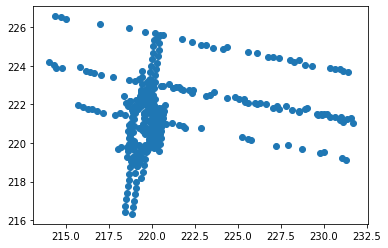

In [101]:
X = n2
clustering = DBSCAN(eps=0.3, min_samples=20).fit(X)
#print(clustering.labels_)

yhat = clustering.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

первая попытка сегментирования в плановом виде без учета высоты.
иногда стабатывает на выделения тела опоры (восновном столбов), но выходит не всегда удачно, особенно на сложных опорах.

далее попробую одномерные графики - плотность по высотной составляющей - должно лучше отделять траверсы (если они без сильного наклона)

In [102]:
n_z = n_s[:,2]   # делаем одномерный массив
n_z[:5]

array([261.46, 261.13, 261.41, 269.85, 261.34])

In [105]:
# двойная разница по высоте в модуле - на столько частей делится выборка - так получается по 0,5м каждая часть
zd = int(abs(n_z.max()- n_z.min())*1)  
zd

26

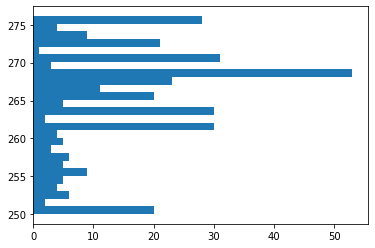

In [106]:
new_a = plt.hist(n_z, zd, orientation='horizontal')

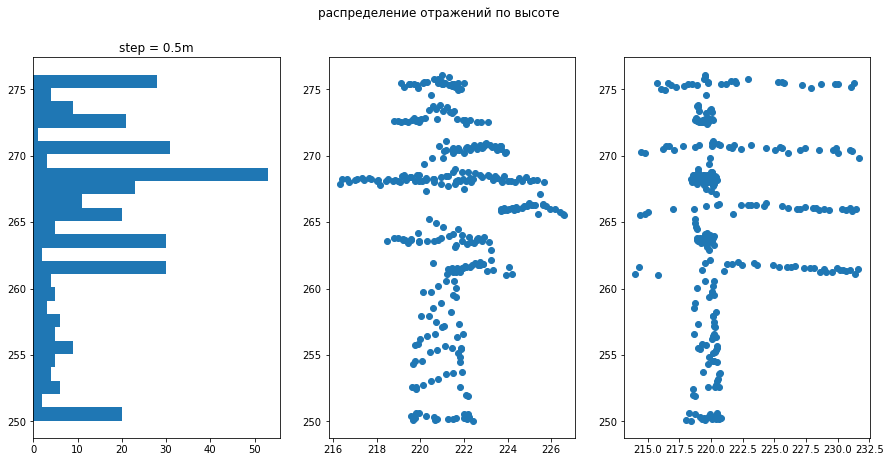

In [107]:
plt.figure(figsize=(15, 7))

plt.subplot(131)  # 1 строка, 3 колонки, 1 колонка
plt.title('step = 0.5m')
plt.hist(n_z, zd, orientation='horizontal')
plt.subplot(132)   # 1 строка, 3 колонки, 2 колонка
plt.plot(n_s[:,1], n_s[:,2], 'o')
plt.subplot(133)
plt.plot(n_s[:,0], n_s[:,2], 'o')

plt.suptitle('распределение отражений по высоте')
plt.show()

как видно на графике по плотности очень хорошо можно находить траверсы, особенно при большом количестве отражений от опоры. На столбах тоже хорошо работает. Дальше нужно будет выделить точки в пиках, и по этим массивам в плане построить прямую (линейную регрессию) которая будет означать угол разворота опоры.  в будущем этот подход позволит также определять нижние кромки траверс.


In [91]:
# при построении графика создался массив new_a[0] 
# каждое значение в new_a[0][х] это количество точек между new_a[1][х] и new_a[1][х+1]

segment = 15
print(f'количество отражений в сегменте №{segment}: {int(new_a[0][segment])} точек')
print(f'дипазон высот этого сегмента: {round(new_a[1][segment], 1)} - {round(new_a[1][segment+1], 1)} m')

количество отражений в сегменте №15: 5 точек
дипазон высот этого сегмента: 26.2 - 26.4 m


In [83]:
np.mean(new_a[0]), np.median(new_a[0])

(6.8558558558558556, 3.0)

In [84]:
max_trav = max(new_a[0][(len(new_a[0])//2):])   # max значение выше середины опоры

In [85]:
level = list(new_a[0]).index(max_trav)    # индекс максимального значения
level

192

In [86]:
print(f'самая большая плотность обнаружена в диапазоне: {round(new_a[1][level], 1)} - {round(new_a[1][level+1], 1)}')
print(f'количество точек: {int(max(new_a[0][(len(new_a[0])//2):]))}')

самая большая плотность обнаружена в диапазоне: 61.7 - 61.9
количество точек: 78


In [92]:
# индекс и величина значений больше среднего (выше середины) 
# возможно тут лучше взять три верхних выброса

ma = []
for nu, i in enumerate(list(new_a[0])):
    if nu > len(new_a[0])//2:
        if i > (np.mean(new_a[0]))*2:
            ma.append((nu, i))
        
print(ma)  

[(125, 25.0), (137, 53.0), (138, 14.0), (164, 37.0), (165, 58.0), (170, 15.0), (192, 78.0), (198, 17.0)]


дальше нужно придумать как отпередять нижнюю часть траверсы (а лучше всю траверсу целиком)